### DDPG
DDPG is closely related to DQN. It can be seen as DQN on continuous action space. The acto in DDPG learns a deterministic policy that maps states to a specific action. The critic is learned similar to DQN. It also applies soft update target network. To avoid divergence, DDPG slowly pulls in the weigts of learned networks into the target networks. This way, it improves stability of learning. Finally DDPG also applies Ornstein-Uhlenbeck process to explore continuous action space.



### Architecture and Hyperparameters
The actor network has 2 hidden layers, each goes through a RELU activation layer. The output layer has a tanh activation function. The critic network also has 2 hidden layers and an output layer. All activation function in critic network is RELU. Also to note that the input dimension of the critic network is the state plus and action space dimension.

Hyperparameters (can be found in ddpg_agent.py file):

- BUFFER_SIZE   # replay buffer size
- BATCH_SIZE         # minibatch size
- GAMMA             # discount factor
- TAU              # for soft update of target parameters
- LR_ACTOR         # learning rate of the actor 
- LR_CRITIC         # learning rate of the critic
- WEIGHT_DECAY         # L2 weight decay
- ACTOR_FC1_UNITS    # Number of units for the layer 1 in the actor model
- ACTOR_FC2_UNITS    # Number of units for the layer 2 in the actor model
- CRITIC_FCS1_UNITS  # Number of units for the layer 1 in the critic model
- CRITIC_FC2_UNITS  # Number of units for the layer 2 in the critic model
- BN_MODE          # Batch normalisation mode
- ADD_OU_NOISE     # Add Ornstein-Uhlenbeck noise
- MU            # Ornstein-Uhlenbeck noise parameter
- THETA            # Ornstein-Uhlenbeck noise parameter
- SIGMA             # Ornstein-Uhlenbeck noise parameter

In [1]:
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt

from ddpg_agent import Agent
from unityagents import UnityEnvironment

In [2]:
env = UnityEnvironment(file_name='Reacher.app')
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

env_info = env.reset(train_mode=True)[brain_name]
action_size = brain.vector_action_space_size
state_size = env_info.vector_observations.shape[1]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
from ddpg_agent import Agent

# Agent default hyperparameters
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 128        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-3         # learning rate of the actor 
LR_CRITIC = 1e-3        # learning rate of the critic
WEIGHT_DECAY = 0        # L2 weight decay
ACTOR_FC1_UNITS = 128   # Number of units for the layer 1 in the actor model
ACTOR_FC2_UNITS = 128   # Number of units for the layer 2 in the actor model
CRITIC_FCS1_UNITS = 128 # Number of units for the layer 1 in the critic model
CRITIC_FC2_UNITS = 128  # Number of units for the layer 2 in the critic model
BN_MODE = 2             # Use Batch Norm. - 0=disabled, 1=BN before Activation, 2=BN after Activation (3, 4 are alt. versions of 1, 2)
ADD_OU_NOISE = True     # Add Ornstein-Uhlenbeck noise
MU = 0.                 # Ornstein-Uhlenbeck noise parameter
THETA = 0.15            # Ornstein-Uhlenbeck noise parameter
SIGMA = 0.2             # Ornstein-Uhlenbeck noise parameter


def ddpg(state_size=state_size, action_size=action_size, random_seed=10, 
         actor_fc1_units=ACTOR_FC1_UNITS, actor_fc2_units=ACTOR_FC2_UNITS,
         critic_fcs1_units=CRITIC_FCS1_UNITS, critic_fc2_units=CRITIC_FC2_UNITS,
         buffer_size=BUFFER_SIZE, batch_size=BATCH_SIZE, bn_mode=BN_MODE,
         gamma=GAMMA, tau=TAU, lr_actor=LR_ACTOR, lr_critic=LR_CRITIC, weight_decay=WEIGHT_DECAY,
         add_ounoise=ADD_OU_NOISE, mu=MU, theta=THETA, sigma=SIGMA, n_episodes=5000, max_t=500):  
    
    # Instantiate the Agent
    agent = Agent(state_size=state_size,action_size=action_size, random_seed=random_seed,
                  actor_fc1_units=actor_fc1_units, actor_fc2_units=actor_fc2_units,
                  critic_fcs1_units=critic_fcs1_units, critic_fc2_units=critic_fc2_units,
                  buffer_size=buffer_size, batch_size=batch_size, bn_mode=bn_mode,
                  gamma=gamma, tau=tau,
                  lr_actor=lr_actor, lr_critic=lr_critic, weight_decay=weight_decay,
                  add_ounoise=add_ounoise, mu=mu, theta=theta, sigma=sigma)
                  
    scores_deque = deque(maxlen=100)
    scores = []

    print("\nStart training:")
    for i_episode in range(1, n_episodes+1):
        
        # Reset the env and get the state (Single Agent)
        env_info = env.reset(train_mode=True)[brain_name]     
        state = env_info.vector_observations[0]
        
        # Reset the DDPG Agent (Reset the internal state (= noise) to mean mu)
        agent.reset()
        
        # Reset the score 
        score = 0
        
        for t in range(max_t):
            action = agent.act(state)                   # select an action 

            env_info=env.step(action)[brain_name]        # send action to the environment
            next_state = env_info.vector_observations[0] # get next state (Single Agent)
            reward = env_info.rewards[0]                 # get reward (Single Agent)
            if reward > 0:
                reward = 0.1
            else:
                reward = 0
            done = env_info.local_done[0]                # see if episode finished (Single Agent)
            
            #if i_episode<2:
            #    print("Debug: steps={} reward={} done={}".format(t,reward,done))
            
            # Save experience in replay memory, and use random sample from buffer to learn
            agent.step(state, action, reward, next_state, done)
            
            state = next_state
            score += reward
            if done:
                #print("Episode {} has terminated at step {}".format(i_episode, t))
                break 
        
        # Save scores and compute average score over last 100 episodes
        scores_deque.append(score)
        scores.append(score)
        avg_score = np.mean(scores_deque)
        
        print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}'.format(i_episode, avg_score, score), end="")

        if avg_score > 30:
                print('\rEnvironment solved in {} episodes with an Average Score of {:.2f}'.format(i_episode, avg_score))
                torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
                torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
                break

        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, avg_score))  

    return scores

In [4]:
scores = ddpg(n_episodes=1500, max_t=1000, 
              actor_fc1_units=128, actor_fc2_units=128,
              critic_fcs1_units=128, critic_fc2_units=128, bn_mode=2,
              gamma=0.99, tau=1e-3, lr_actor=1e-3, lr_critic=1e-3, weight_decay=0.,
              add_ounoise=True, mu=0., theta=0.15, sigma=0.1)

env.close()


[INFO]ddpg constructor called with parameters: state_size=33 action_size=4 random_seed=10 actor_fc1_units=128 actor_fc2_units=128 critic_fcs1_units=128 critic_fc2_units=128 buffer_size=100000 batch_size=128 gamma=0.99 tau=0.001 bn_mode=2 lr_actor=0.001 lr_critic=0.001 weight_decay=0.0 add_ounoise=True mu=0.0 theta=0.15 sigma=0.1 


Start training:
Episode 100	Average Score: 10.66
Episode 200	Average Score: 25.91
Environment solved in 214 episodes with an Average Score of 30.02


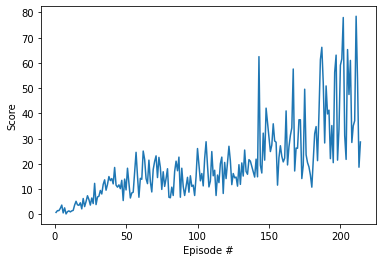

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### Future work
1. We can try hyperparameter tuning and change network architecture (num of nodes and num of layers etc).
2. Instead of DDPG, we can explore other policy gradients based methods such as A2C, GAE, TD3.